In [33]:
%matplotlib inline


In [3]:
from __future__ import print_function, division

import imageio


import tensorflow.compat.v1 as tf
#import tensorflow_probability as tfp
import tensorflow_datasets as tfds
import numpy as np

import os
import warnings

from functools import partial

# Dependency imports
from absl import app
from absl import flags
import matplotlib
matplotlib.use('Agg')
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg



from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout,Layer
from tensorflow.keras.layers import Lambda, Concatenate, BatchNormalization, Activation, ZeroPadding2D,LeakyReLU,UpSampling2D, Conv2D,Add, LayerNormalization
from tensorflow.keras.layers import Cropping2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop
from functools import partial

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import sys

from random import choice

import pdb

In [72]:
class TransformationLayer(Layer):
    def __init__(self, layers=6, dim=392):
        super(TransformationLayer, self).__init__()
        self.dense_layers = [Dense(1000, activation=LeakyReLU(alpha=0.1)) for _ in range(layers-1)]
        self.final = Dense(dim, activation=LeakyReLU(alpha=0.1))
        self.layers = layers
    def call(self, inputs):
        output = inputs
        for dense in self.dense_layers:
            output = dense(output)
        output = self.final(output)
        return output
 
class CoupleLayer(Layer):
    def __init__(self, transform_layer):
        super(CoupleLayer, self).__init__()
        self.m = transform_layer
    def call(self, inputs):
        y1 = inputs[0]
        y2 = inputs[1] + inputs[2] #x2 + mx1
        return y1, y2
    def inverse(self, inputs):
        x1 = inputs[0]
        x2 = inputs[1] - inputs[2] #x2 + mx1
        return x1, x2

class SplitLayer(Layer):
    def __init__(self, dim=784):
        super(SplitLayer, self).__init__()
        self.cutoff = int(dim/2)
        
    def call(self, inputs):
        return inputs[:, :self.cutoff], inputs[:, self.cutoff:]
    def inverse(self, inputs):
        output = K.concatenate([inputs[0], inputs[1]], axis=1)
        return output
    
class ConcatLayer(Layer):
    def __init__(self, dim):
        super(ConcatLayer, self).__init__()
        self.cutoff = int(dim/2)
    def call(self, inputs):
        output = K.concatenate([inputs[0], inputs[1]], axis=1)
        return output
    def inverse(self, inputs):
        return inputs[:, :self.cutoff], inputs[:, self.cutoff:]
    
class PartitionLayer(Layer):
    def __init__(self, part_mode='even_odd', orientation=0):
        super(PartitionLayer, self).__init__()
        self.idx = None
        self.part_mode = part_mode
        self.orientation= orientation
    def call(self, inputs):
        dim = K.int_shape(inputs)[-1]
        if self.idx == None:
            self.idx = list(range(dim))
            if self.part_mode == 'reverse':
                self.idx = self.idx[::-1]
            elif self.part_mode == 'random':
                np.random.shuffle(self.idx)
            elif self.part_mode=='even_odd':
                self.idx = np.array(self.idx)
                temp = np.reshape(self.idx, (int(dim/2), 2)) 
                left = temp[:,0]
                right = temp[:,1]
                if self.orientation == 1:
                    self.idx = list(np.append(left, right))
                else:
                    self.idx = list(np.append(right, left))
        inputs = K.transpose(inputs)
        outputs = K.gather(inputs, self.idx)
        outputs = K.transpose(outputs)
        return outputs
    def inverse(self, inputs):
        dim = len(self.idx)
        _ = sorted(zip(range(dim), self.idx), key=lambda s: s[1])
        reverse_idx = [i[0] for i in _]
        inputs = K.transpose(inputs)
        outputs = K.gather(inputs, reverse_idx)
        outputs = K.transpose(outputs)
        return outputs


class ScaleLayer(Layer): # Hadamard product
    def __init__(self):
        super(ScaleLayer, self).__init__()
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', shape=input_shape[1:], initializer='uniform', trainable=True)
        #super(ScaleLayer, self).build(input_shape)
    def call(self, inputs):
        self.add_loss(-1*K.sum(scale.kernel))
        return inputs*K.exp(self.kernel)
    def inverse(self, inputs):
        return inputs*K.exp(-self.kernel)

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# reshape into 1 dimension


In [5]:
type(x_train)

numpy.ndarray

In [6]:
np.shape(x_train)
x_train_reshaped = x_train.astype('float32') / 255

In [7]:
x_train_reshaped = np.reshape(x_train_reshaped, (60000, 28*28))

In [8]:
tf.executing_eagerly()

True

In [76]:
class NICE():
    def __init__(self, coupling_layers=4, prior='logistic', total_dim=784, img_dim=(28,28)):
        # prior loss
        self.prior = prior
        self.total_dim = total_dim
        self.img_dim = img_dim
        self.split = SplitLayer(dim=self.total_dim)
        # layers into boy
        # keep a functional version too. Makes sense to me.
        self.transform1 = TransformationLayer()
        self.transform2 = TransformationLayer()
        self.transform3 = TransformationLayer()
        self.transform4 = TransformationLayer()

        self.couple1 = CoupleLayer(self.transform1)
        self.couple2 = CoupleLayer(self.transform2)
        self.couple3 = CoupleLayer(self.transform3)
        self.couple4 = CoupleLayer(self.transform4)

        self.concat = ConcatLayer()
        self.scale = ScaleLayer()
        self.partition1 = PartitionLayer(orientation=1, part_mode='even_odd')
        self.partition2 = PartitionLayer(orientation=0)
        self.partition3 = PartitionLayer(orientation=1)
        self.partition4 = PartitionLayer(orientation=0)
        
        self.partial_scale_loss = partial(self.scale_loss, scale=self.scale)
        self.partial_scale_loss.__name__ = "scale"

        partial_total_loss = partial(total_loss, scale=self.scale)
        partial_total_loss.__name__ = 'total'

        optimizer = tf.keras.optimizers.Adam(lr=0.0001, epsilon=1e-4, beta_2=0.01)
        self.encoder = self.build_encoder()
        # this shit broke as fuck, be careful
        encoder.compile(loss = [self.ml_loss, self.scale_loss], optimizer=optimizer, metrics=[ml_loss, self.partial_scale_loss], loss_weights=[1, 1])
        #encoder.compile(loss = partial_total_loss, optimizer=optimizer, metrics=[partial_total_loss, ml_loss, self.partial_scale_loss])
        #encoder.compile(loss = ml_loss, optimizer=optimizer, metrics=[partial_total_loss, ml_loss, self.partial_scale_loss])
        self.decoder = None # initialize after training
        
    def build_encoder(self):
        img_shape = (28*28)
        img = Input(shape=(28*28))
        #img2 = Lambda(lambda s: K.in_train_phase(s-0.01*K.random_uniform(K.shape(s)), s))(img)
        # self.partition
        # self.split in half = x1 x2
        partitiond = self.partition1(img)
        x1, x2 = self.split(partitiond)
        # do a self.transform
        mx1 = self.transform1(x1)
        # self.couple x2 + m*(x1)
        y1, y2 = self.couple1([x1, x2, mx1])
        y = self.concat([y1, y2])

        y = self.partition2(y)
        x1, x2 = self.split(y)
        # do a self.transform
        mx1 = self.transform2(x1)
        # self.couple x2 + m*(x1)
        y1, y2 = self.couple2([x1, x2, mx1])
        y = self.concat([y1, y2])

        y = self.partition3(y)
        x1, x2 = self.split(y)
        # do a self.transform
        mx1 = self.transform3(x1)
        # self.couple x2 + m*(x1)
        y1, y2 = self.couple3([x1, x2, mx1])
        y = self.concat([y1, y2])

        y = self.partition4(y)
        x1, x2 = self.split(y)
        # do a self.transform
        mx1 = self.transform4(x1)
        # self.couple x2 + m*(x1)
        y1, y2 = self.couple4([x1, x2, mx1])
        y = self.concat([y1, y2])
        y = self.scale(y)

        # don't forget the loss of the self.scale
        encoder = Model([img], [y])
        encoder.summary()
        return encoder
    
    def scale_loss(self, y_true, y_pred, scale): 
        return -1*K.sum(self.scale.kernel)
    
    def ml_loss(self, y_true, y_pred):
        loss = None
        if self.prior == 'gaussian':
            loss = K.sum(0.5 * y_pred**2, 1)
        elif self.prior == 'logistic':
            loss = K.sum ( K.softplus(y_pred) + K.softplus(-y_pred), axis=1 )
        return loss

    def total_loss(self, y_true, y_pred, scale):
        return self.ml_loss(y_true, y_pred) + self.scale_loss(y_true, y_pred, self.scale)

    def train(self, x_train, batch_size=256, epochs=10):
        encoder.fit(x_train, x_train, batch_size=batch_size, epochs=epochs, verbose=2)

    def build_decoder(self):
        latent = Input(shape=(self.total_dim))
        sample_inversed = self.scale.inverse(latent)

        y1, y2 = self.concat.inverse(sample_inversed)
        my1 = self.transform4(y1)
        x1, x2 = self.couple4.inverse([y1, y2, my1]) 
        x = self.split.inverse([x1, x2])
        x = self.partition4.inverse(x)

        y1, y2 = self.concat.inverse(x)
        my1 = self.transform3(y1)
        x1, x2 = self.couple3.inverse([y1, y2, my1]) 
        x = self.split.inverse([x1, x2])
        x = self.partition3.inverse(x)

        y1, y2 = self.concat.inverse(x)
        my1 = self.transform2(y1)
        x1, x2 = self.couple2.inverse([y1, y2, my1]) 
        x = self.split.inverse([x1, x2])
        x = self.partition2.inverse(x)

        y1, y2 = self.concat.inverse(x)
        my1 = self.transform1(y1)
        x1, x2 = self.couple1.inverse([y1, y2, my1]) 
        x = self.split.inverse([x1, x2])
        x = self.partition1.inverse(x)

        decoder = Model([latent], [x])
        decoder.summary()
        self.decoder = decoder
    def sample(self, noise):
        if self.decoder:
            return self.decoder(noise)
        return None
    
    def sample_to_file(self, rows):
        figure = np.zeros((self.img_size[0] * n, self.img_size[0] * n))
        
        for i in range(rows):
            for j in range(rows):
                z_sample = np.array(np.random.randn(1, self.total_dim)) * 0.75
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(self.img_size[0], self.img_size[0])
                figure[i * self.img_size[0]: (i + 1) * self.img_size[0],
                       j * self.img_size[0]: (j + 1) * self.img_size[0]] = digit

        figure = np.clip(figure*255, 0, 255)
        imageio.imwrite('test.png', figure)


In [67]:
nice = NICE()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
partition_layer_41 (PartitionLa (None, 784)          0           input_10[0][0]                   
__________________________________________________________________________________________________
split_layer_17 (SplitLayer)     ((None, 392), (None, 0           partition_layer_41[0][0]         
                                                                 partition_layer_42[0][0]         
                                                                 partition_layer_43[0][0]         
                                                                 partition_layer_44[0][0]   

If our model works, it should perfectly return an input sample, even before training,

In [71]:
nice.build_decoder()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_Mul_4 (TensorFlowOp [(None, 784)]        0           input_13[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_26 (T [(None, 392)]        0           tf_op_layer_Mul_4[0][0]          
__________________________________________________________________________________________________
tf_op_layer_strided_slice_27 (T [(None, 392)]        0           tf_op_layer_Mul_4[0][0]          
____________________________________________________________________________________________

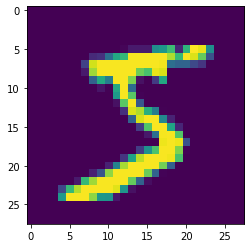

In [69]:
plt.imshow(np.reshape(x_train_reshaped[0]*255, (28, 28)))

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 784)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_Mul_3 (TensorFlowOp [(None, 784)]        0           input_12[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_18 (T [(None, 392)]        0           tf_op_layer_Mul_3[0][0]          
__________________________________________________________________________________________________
tf_op_layer_strided_slice_19 (T [(None, 392)]        0           tf_op_layer_Mul_3[0][0]          
____________________________________________________________________________________________

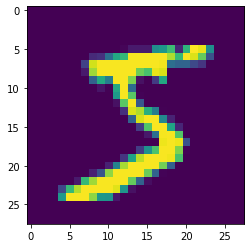

In [70]:
sample = nice.encoder(x_train_reshaped[0:1])
plt.imshow(np.reshape(nice.sample(sample)[0]*255, (28, 28)))

In [65]:
nice.train(x_train_reshaped)

Epoch 1/10


/home/kchow/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


235/235 - 2s - loss: 1090.0120 - ml_loss: 1100.6116 - scale: 0.6713
Epoch 2/10
235/235 - 2s - loss: 1067.2042 - ml_loss: 1096.2172 - scale: 0.6713
Epoch 3/10
235/235 - 2s - loss: 1047.5137 - ml_loss: 1094.9469 - scale: 0.6713
Epoch 4/10
235/235 - 2s - loss: 1028.5917 - ml_loss: 1094.4462 - scale: 0.6713
Epoch 5/10
235/235 - 2s - loss: 1009.9269 - ml_loss: 1094.2032 - scale: 0.6713
Epoch 6/10
235/235 - 2s - loss: 991.3970 - ml_loss: 1094.0959 - scale: 0.6713
Epoch 7/10
235/235 - 2s - loss: 972.9176 - ml_loss: 1094.0382 - scale: 0.6713
Epoch 8/10
235/235 - 2s - loss: 954.5137 - ml_loss: 1094.0574 - scale: 0.6713
Epoch 9/10
235/235 - 2s - loss: 936.1445 - ml_loss: 1094.1100 - scale: 0.6713
Epoch 10/10
235/235 - 2s - loss: 917.8488 - ml_loss: 1094.2375 - scale: 0.6713


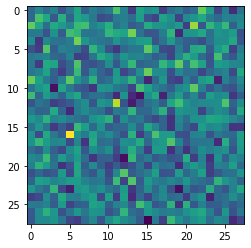

In [78]:
samples = np.random.randn(10, 28*28)*0.75
samples = nice.sample(samples)
plt.imshow(np.reshape(samples[1]*255, (28, 28)))